# Advanced Lane Lines and Vehicle Detection

### Imports, Tools, Configuration

In [134]:
import numpy as np
import cv2
import glob
import time
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
# from sklearn.model_selection import train_test_split # >= 0.18 TODO
from sklearn.cross_validation import train_test_split # 0.17
from sklearn import grid_search
from scipy.ndimage.measurements import label

%matplotlib qt

# Configuration
SRC_TF = np.float32([ [262.0, 680.0], [1042.0, 680.0], [701.0, 460.0], [580.0, 460.0] ])
DST_TF = np.float32([ [262.0, 720.0], [1042.0, 720.0], [1042.0, 0.0], [262.0, 0.0] ])

# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

HISTORY_SIZE = 50

ksize=5

np.set_printoptions(precision=6, suppress=True)

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.reset()
        
    def reset(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        self.best_fit_amnt = 0
        #polynomial coefficients for the most recent fit
        self.current_fit = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # avg number of points in a fit
        self.average_fit_points = 0.0
        # amount of fit points
        self.amnt_fit_points = []
    
    def addToAverageFitPoints(self, fit_points):
        self.amnt_fit_points.append(float(len(fit_points)))
        
        if len(self.amnt_fit_points) > HISTORY_SIZE:
            del self.amnt_fit_points[0]
            
        self.average_fit_points = sum(self.amnt_fit_points) / float(len(self.amnt_fit_points))
    
    def addToAverageBestFit(self, fit, img_shape):
        self.averageOverCurrentFit(fit, img_shape)
        #self.averageOverXFitted(fit, img_shape)
    
    def averageOverCurrentFit(self, fit, img_shape):
        self.current_fit.append(fit)
        if len(self.current_fit) > HISTORY_SIZE:
            del self.current_fit[0]
        sum_fit = np.zeros_like(fit)
        for prev_fit in self.current_fit:
            sum_fit += prev_fit
        
        self.best_fit = sum_fit / len(self.current_fit)
    
    def averageOverXFitted(self, fit, img_shape):
        
        if len(self.recent_xfitted) > HISTORY_SIZE:
            del self.recent_xfitted[0]
        
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
        plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
        
        self.recent_xfitted.append(plotx)
        
        complete_y = []
        complete_x = []
        for prev_xfitted in self.recent_xfitted:
            complete_y.extend(ploty)
            complete_x.extend(prev_xfitted)
            
        self.best_fit = np.polyfit(complete_y, complete_x, 2)
        
        
    def toStrings(self):
        return ["Best fit: " + str(self.best_fit), 
                "Detected? " + str(self.detected), 
                "CurFit length: " + str(len(self.current_fit)),
                "Xfitted length: " + str(len(self.recent_xfitted)),
                "Avg Fit Points: " + str(self.average_fit_points)]
        
        
class ImageDisplay():
    def __init__(self, image, label, cmap_str):
        self.image = image
        self.label = label
        self.cmap_str = cmap_str

def wAvg(val1, w1, val2, w2):
    return (val1 * w1 + val2 * w2) / 2.0

def calibrate(nx, ny):
    
    objpoints = []
    imgpoints = []
    
    images = glob.glob('camera_cal/calibration*.jpg')
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        objp = np.zeros((nx*ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True: # meaning that we found chessboard corners
            imgpoints.append(corners)
            objpoints.append(objp)
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            cv2.imshow('img', img)
            cv2.waitKey(500)
            
    cv2.destroyAllWindows()

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

def thresh(gray, thresh=(0, 255)):
    binary_output = np.zeros_like(gray)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(gray >= thresh[0]) & (gray <= thresh[1])] = 1

    # Return the result
    return binary_output

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    if thresh is not None:
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
        # Return the binary image
        return binary_output
    
    return gradmag

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def perspective_transform(img):
    M = cv2.getPerspectiveTransform(SRC_TF, DST_TF)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

def inverse_perspective_transform(img):
    Minv = cv2.getPerspectiveTransform(DST_TF, SRC_TF)
    warped = cv2.warpPerspective(img, Minv, (img.shape[1], img.shape[0]))
    return warped

def gray(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray

def HLS(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls

def YUV(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return yuv

def YCrCb(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return ycrcb

def H(img):
    hls = HLS(img)
    return hls[:,:,0]

def L(img):
    hls = HLS(img)
    return hls[:,:,1]

def S(img):
    hls = HLS(img)
    return hls[:,:,2]

def Y(img):
    yuv = YUV(img)
    return yuv[:,:,0]

def U(img):
    yuv = YUV(img)
    return yuv[:,:,1]

def V(img):
    yuv = YUV(img)
    return yuv[:,:,2]

def Y(img):
    ycrcb = YCrCb(img)
    return ycrcb[:,:,0]

def Cr(img):
    ycrcb = YCrCb(img)
    return ycrcb[:,:,1]

def Cb(img):
    ycrcb = YCrCb(img)
    return ycrcb[:,:,2]

def get_histogram(binary_warped, ratio=2.0):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2.0):,:], axis=0)
    return histogram

def sliding_window(binary_warped, histogram=None):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    if histogram is None:
        histogram = get_histogram(binary_warped)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    out_img = draw_polygon_with_margin_around_polynomial(out_img, left_fit, 20)
    out_img = draw_polygon_with_margin_around_polynomial(out_img, right_fit, 20)
    
    texts = []
    #texts.extend(left_line.toStrings())
    #texts.extend(right_line.toStrings())
    #texts.append("Current Fit Points: L " + str(len(left_lane_inds)) + ",   R " + str(len(right_lane_inds)))
    
    out_img = addText(out_img, texts)
    
    return out_img, left_fit, right_fit

def draw_polygon_with_margin_around_polynomial(out_img, polynomial, margin, color=(0, 255, 0)):
    window_img = np.zeros_like(out_img)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    plotx = polynomial[0]*ploty**2 + polynomial[1]*ploty + polynomial[2]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    poly_window1 = np.array([np.transpose(np.vstack([plotx-margin, ploty]))])
    poly_window2 = np.array([np.flipud(np.transpose(np.vstack([plotx+margin, ploty])))])
    poly_pts = np.hstack((poly_window1, poly_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([poly_pts]), color)
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result

def draw_polygon_between_polynomials(out_img, left_fit, right_fit):
    window_img = np.zeros_like(out_img)
    
    ploty = np.linspace(0, out_img.shape[0]-1, out_img.shape[0] )
    
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(window_img, np.int_([pts]), (0, 255, 0))
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result

def draw_lane_undistorted(undistd, left_fit, right_fit):
    
    # Create an image to draw the lines on
    #lane_zeros = np.zeros_like(undistd).astype(np.uint8)
    #lane_color = np.dstack((lane_zeros, lane_zeros, lane_zeros))
    lane_color = np.zeros_like(undistd)
    
    # draw the lane in top-down view, on the blank image
    lane_color = draw_polygon_between_polynomials(lane_color, left_fit, right_fit)
    
    # warp the lane back into the viewpoint of the car camera
    lane_color_warped = inverse_perspective_transform(lane_color)
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistd, 1, lane_color_warped, 0.3, 0)
    
    return result

def detect_from_previous(binary_warped, left_fit, right_fit):
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    result = draw_polygon_with_margin_around_polynomial(out_img, left_fit, margin)
    result = draw_polygon_with_margin_around_polynomial(result, right_fit, margin)
    #result = draw_polygon_with_margin_around_polynomial(result, left_line.best_fit, margin, color=(0, 0, 255))
    #result = draw_polygon_with_margin_around_polynomial(result, right_line.best_fit, margin, color=(0, 0, 255))
    
    texts = []
    #texts.append("Current Fit Points: L " + str(len(left_lane_inds)) + ",   R " + str(len(right_lane_inds)))
    
    out_img = addText(out_img, texts)
    
    #result = draw_polygon_between_polynomials(result, left_fit, right_fit)
    
    return result, left_fit, right_fit

def lane_offset(left_fit, right_fit, lane_img):
    lowestX_left = getLowestXPos(left_fit, lane_img)
    lowestX_right = getLowestXPos(right_fit, lane_img)
    avg = (lowestX_left + lowestX_right) / 2.0
    center = lane_img.shape[1]/2.0
    offset = avg - center
    return xToM(offset)

def xToM(x):
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    return x * xm_per_pix

def getLowestXPos(fit, img):
    
    # Fit new polynomials to x,y in world space
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    # Generate x and y values for plotting
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    
    return fitx[0]

def measure_curvature(fit, img):
    
    # measure curvature in pixel space
    y_eval = np.max(img.shape[0])
    px_curverad = ((1 + (2*fit[0]*y_eval + fit[1])**2)**1.5) / np.absolute(2*fit[0])

    # measure curvature in real world
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    
    # Generate x and y values for plotting
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    world_curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    return px_curverad, world_curverad

def undist(image):
    return cv2.undistort(image, mtx, dist, None, mtx)
        
def process_image_find_cspace(image):
    undistd = undist(image)
    persp = perspective_transform(undistd)
    return concatenate_4_images(undistd, H(undistd), L(undistd), S(undistd))

def process_image_video1(image):
    undistd = image # here we assume that the image is already undistorted
    #undistd = undist(image)
    persp = perspective_transform(undistd)
    gradx = abs_sobel_thresh(L(persp), orient='x', sobel_kernel=ksize, thresh=(10, 100))
    
    global left_line, right_line
    
    if (left_line.detected and right_line.detected):
        result, left_fit, right_fit = detect_from_previous(gradx, left_line.best_fit, right_line.best_fit)
        
        # average best fit
        left_line.addToAverageBestFit(left_fit, result.shape)
        right_line.addToAverageBestFit(right_fit, result.shape)

    else:
        result, left_fit, right_fit = sliding_window(gradx)
        
        left_line.detected = True
        right_line.detected = True
        
        # average best fit
        left_line.addToAverageBestFit(left_fit, result.shape)
        right_line.addToAverageBestFit(right_fit, result.shape)
    
    result_warped = draw_lane_undistorted(undistd, left_line.best_fit, right_line.best_fit)
    
    texts = []
    
    if left_line.detected:
        left_px_curverad, left_world_curverad = measure_curvature(left_line.best_fit, gradx)
        left_line.radius_of_curvature = left_world_curverad
        texts.append("Left World Curverad: " + str(left_world_curverad))
    
    if right_line.detected:
        right_px_curverad, right_world_curverad = measure_curvature(right_line.best_fit, gradx)
        right_line.radius_of_curvature = right_world_curverad
        texts.append("Right World Curverad: " + str(right_world_curverad))
    
    if left_line.detected and right_line.detected:
        offset = lane_offset(left_line.best_fit, right_line.best_fit, gradx)
        texts.append("Lane Offset: " + str(offset))
    
    result_warped = addText(result_warped, texts)
    
    #return concatenate_4_images(image, gradx, result, result_warped)
    return result_warped

def process_image_video2(image):
    try:
        undistd = image # here we assume that the image is already undistorted
        #undistd = undist(image)
        persp = perspective_transform(undistd)
        gradx = abs_sobel_thresh(L(persp), orient='x', sobel_kernel=ksize, thresh=(30, 100))

        left_lane_line = np.zeros_like(gradx)
        thresholded_L = thresh(L(persp), thresh=(130, 255))
        thresholded_S = thresh(S(persp), thresh=(15, 255))
        left_lane_line[(thresholded_L == 1) & (thresholded_S == 1)] = 1

        right_lane_line = thresh(L(persp), thresh=(180, 255))
        right_lane_line_strict = np.zeros_like(gradx)
        right_lane_line_strict[(right_lane_line == 1) & (gradx == 1)] = 1

        both_lane_lines = np.zeros_like(gradx)
        both_lane_lines[(left_lane_line == 1) | (right_lane_line_strict == 1)] = 1

        global left_line, right_line
        
        if (left_line.detected and right_line.detected):
            result, left_fit, right_fit = detect_from_previous(both_lane_lines, left_line.best_fit, right_line.best_fit)

            # average best fit
            left_line.addToAverageBestFit(left_fit, result.shape)
            right_line.addToAverageBestFit(right_fit, result.shape)

        else:
            histogram = get_histogram(both_lane_lines, ratio=1.4)
            result, left_fit, right_fit = sliding_window(both_lane_lines, histogram)

            left_line.detected = True
            right_line.detected = True

            # average best fit
            left_line.addToAverageBestFit(left_fit, result.shape)
            right_line.addToAverageBestFit(right_fit, result.shape)
        
        result_warped = draw_lane_undistorted(undistd, left_line.best_fit, right_line.best_fit)
    
        texts = []

        if left_line.detected:
            left_px_curverad, left_world_curverad = measure_curvature(left_line.best_fit, gradx)
            left_line.radius_of_curvature = left_world_curverad
            texts.append("Left World Curverad: " + str(left_world_curverad))
            texts.append("Left Px Curverad: " + str(left_px_curverad))

        if right_line.detected:
            right_px_curverad, right_world_curverad = measure_curvature(right_line.best_fit, gradx)
            right_line.radius_of_curvature = right_world_curverad
            texts.append("Right World Curverad: " + str(right_world_curverad))
            texts.append("Right Px Curverad: " + str(right_px_curverad))
            
        if left_line.detected and right_line.detected:
            offset = lane_offset(left_line.best_fit, right_line.best_fit, gradx)
            texts.append("Lane Offset: " + str(offset))

        result_warped = addText(result_warped, texts)
        ''
        #return concatenate_4_images(left_lane_line, right_lane_line, result, result_warped)
        return result_warped
    except:
        #return concatenate_4_images(left_lane_line, right_lane_line, both_lane_lines, both_lane_lines)
        #return both_lane_lines
        return undistd
    
def process_image(image):

    #image_o = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    #cv2.imwrite("test_images/test_challenge_4.jpg", image_o)
    
    undistd = undist(image)
    persp = perspective_transform(undistd)
    #gradx = abs_sobel_thresh(Y(persp), orient='x', sobel_kernel=ksize, thresh=(50, 200)) # was 10,100

    #mag_L = mag_thresh(L(persp), thresh=(50, 200))
    #mag_Y = mag_thresh(Y(persp), thresh=None)
    #mag_U = mag_thresh(U(persp), thresh=(50, 200))
    #mag_S = mag_thresh(S(persp), thresh=(50, 200))
    
    #left_lane_line = np.zeros_like(gradx)
    #thresholded_L = thresh(L(persp), thresh=(130, 255))
    thresholded_Y = thresh(Y(persp), thresh=(200, 255))
    thresholded_V = thresh(V(persp), thresh=(150, 255))
    thresholded_L = thresh(L(persp), thresh=(180, 255))
    thresholded_H = thresh(H(persp), thresh=(100, 102))
    #left_lane_line[(thresholded_L == 1) & (thresholded_S == 1)] = 1

    #right_lane_line = thresh(L(persp), thresh=(180, 255))
    #right_lane_line_strict = np.zeros_like(gradx)
    #right_lane_line_strict[(right_lane_line == 1) & (gradx == 1)] = 1



    #both_lane_lines = np.zeros_like(gradx)
    #both_lane_lines[(left_lane_line == 1) | (right_lane_line_strict == 1)] = 1

    #global left_line, right_line

    #result_sl, left_line, right_line = sliding_window(both_lane_lines, left_line, right_line)
    #if (left_line.detected and right_line.detected):
    #    result, left_line, right_line = detect_from_previous(both_lane_lines, left_line, right_line)

    return concatenate_4_images(thresholded_Y, thresholded_L, thresholded_H, thresholded_V)

def addText(image, texts):
    y = 100
    y_offset = 50
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    for text in texts:
        image = cv2.putText(image, text, (50, y), font, 1,(0,0,255),3)
        y += y_offset
    
    return image

def grayToColor(image):
    if (len(image.shape) < 3):
        return np.dstack((image, image, image))*255
    return image

def concatenate_4_images(image1, image2, image3, image4):
    image1 = grayToColor(image1)
    image2 = grayToColor(image2)
    image3 = grayToColor(image3)
    image4 = grayToColor(image4)
    
    left = np.concatenate((image1, image3), axis=0)
    right = np.concatenate((image2, image4), axis=0)
    return np.concatenate((left, right), axis=1)

def show_multiple(image_displays):
    fontsize = 10
    figsize = (20, 10)
    cols = 2
    
    rows = math.ceil(len(image_displays) / cols)
    print("image canvas with", cols, "cols and", rows, "rows")
    
    f, ( canvas ) = plt.subplots(rows, cols, figsize=figsize)
    
    for image_display_index in range(len(image_displays)):
        image_display = image_displays[image_display_index]
        
        if rows > 1:
            row = math.floor( float(image_display_index) / float(cols))
            col = image_display_index % cols
            print(image_display.label, "goes to", str(row), str(col))
            ax = canvas[row][col]
        else:
            ax = canvas[image_display_index]     
        
        ax.imshow(image_display.image, cmap=image_display.cmap_str)
        ax.set_title(image_display.label, fontsize=fontsize)
    

In [ ]:
# Graveyard

def find_matches(img, template_list):
    # Make a copy of the image to draw on
    # Define an empty list to take bbox coords
    bbox_list = []
    # Iterate through template list
    # Read in templates one by one
    method = cv2.TM_CCOEFF_NORMED
    for tmp_path in template_list:
        tmp = mpimg.imread(tmp_path)
        result = cv2.matchTemplate(img, tmp, method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        #print(min_val, max_val, min_loc, max_loc)
        w, h = (tmp.shape[1], tmp.shape[0])
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # Append bbox position to list
        bbox_list.append((top_left, bottom_right))
    return bbox_list

def plot_color_hist(rh, gh, bh, bincen, feature_vec):
    # Plot a figure with all three bar charts
    if rh is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bincen, rh[0])
        plt.xlim(0, 256)
        plt.title('R Histogram')
        plt.subplot(132)
        plt.bar(bincen, gh[0])
        plt.xlim(0, 256)
        plt.title('G Histogram')
        plt.subplot(133)
        plt.bar(bincen, bh[0])
        plt.xlim(0, 256)
        plt.title('B Histogram')
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')

def draw_sliding_window_boxes(image):
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
    window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
    plt.imshow(window_img)

def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

def explore_color(img_path): # TODO img as argument
    # Read a color image
    img = cv2.imread(img_path)

    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_HLS = cv2.cvtColor(img_small, cv2.COLOR_BGR2HLS)
    img_small_YUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YUV)
    img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

    # Plot and show
    plot3d(img_small_RGB, img_small_rgb)
    plt.show()

    plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    plt.show()
    
    plot3d(img_small_HLS, img_small_rgb, axis_labels=list("HLS"))
    plt.show()
    
    plot3d(img_small_YUV, img_small_rgb, axis_labels=list("YUV"))
    plt.show()
    
    plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
    plt.show()

def normalize_and_show_features():
    images = glob.glob('*.jpeg')
    cars = []
    notcars = []
    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)

    car_features = extract_features(cars, cspace='RGB', spatial_size=(32, 32),
                            hist_bins=32, hist_range=(0, 256))
    notcar_features = extract_features(notcars, cspace='RGB', spatial_size=(32, 32),
                            hist_bins=32, hist_range=(0, 256))

    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        car_ind = np.random.randint(0, len(cars))
        # Plot an example of raw and scaled features
        fig = plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.imshow(mpimg.imread(cars[car_ind]))
        plt.title('Original Image')
        plt.subplot(132)
        
def parameter_tuning():
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svr = svm.SVC()
    clf = grid_search.GridSearchCV(svr, parameters)
    clf.fit(iris.data, iris.target)

In [ ]:
class Singleton(type):
    _instances = {}
    def __call__(cls, *args, **kwargs):
        if cls not in cls._instances:
            cls._instances[cls] = super(Singleton, cls).__call__(*args, **kwargs)
        return cls._instances[cls]

class Configuration(metaclass=Singleton):
    def __init__(self):
        self.COLOR_SPACE = "YCrCb"
        self.SPATIAL_SIZE = (16, 16)
        self.HIST_BINS = 16
        self.ORIENTATIONS = 9
        self.PIX_PER_CELL = 8
        self.CELLS_PER_BLOCK = 2
        self.HOG_CHANNEL = "ALL"
        self.SPATIAL_FEAT = True
        self.HIST_FEAT = True
        self.HOG_FEAT = True
        self.SCALE = 1.5
        self.HIST_RANGE = (0, 1)
        self.Y_START_STOP = [400, 670]
        
class RuntimeData(metaclass=Singleton):
    def __init__(self):
        self.reset()
        self.resetCaches()
    
    def reset(self):
        self.heatmap = None
        self.index = 0
    
    def resetCaches(self):
        self.bbox_list_cache = []
        self.draw_img_cache = []
    
    def addToCaches(self, draw_img, bbox_list):
        self.bbox_list_cache.append(bbox_list)
        self.draw_img_cache.append(draw_img)
    
    def getNextCache(self):
        draw_img, bbox_list = self.draw_img_cache[self.index], self.bbox_list_cache[self.index]
        self.index += 1
        return draw_img, bbox_list

In [135]:
def read_image(img_file):
    image = mpimg.imread(img_file)
    raw_image = np.copy(image)
    
    if ".jpg" in img_file or ".JPG" in img_file:
        image = image.astype(np.float32)/255
    
    return image, raw_image
    
def convert_color(img, src, tgt):
    return convert_from_RGB(img, tgt)

def convert_from_RGB(img, tgt):
    if tgt != 'RGB':
        if tgt == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif tgt == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif tgt == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif tgt == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif tgt == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        return np.copy(img)
        
    return None

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def single_img_features(img):
                
    color_space = Configuration().COLOR_SPACE
    spatial_size = Configuration().SPATIAL_SIZE
    hist_bins = Configuration().HIST_BINS
    orient = Configuration().ORIENTATIONS
    pix_per_cell = Configuration().PIX_PER_CELL
    cell_per_block = Configuration().CELLS_PER_BLOCK
    hog_channel = Configuration().HOG_CHANNEL
    spatial_feat = Configuration().SPATIAL_FEAT
    hist_feat = Configuration().HIST_FEAT
    hog_feat = Configuration().HOG_FEAT
    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, "RGB", color_space)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def extract_features(imgs):
    features = []
    for file in imgs:
        file_features = []
        image, raw_image = read_image(file)
        features.append(single_img_features(image))
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def find_cars(img, draw_img, svc, X_scaler):
    
    color_space = Configuration().COLOR_SPACE
    ystart = Configuration().Y_START_STOP[0]
    ystop = Configuration().Y_START_STOP[1]
    scale = Configuration().SCALE
    orient = Configuration().ORIENTATIONS
    pix_per_cell = Configuration().PIX_PER_CELL
    cell_per_block = Configuration().CELLS_PER_BLOCK
    spatial_size = Configuration().SPATIAL_SIZE
    hist_bins = Configuration().HIST_BINS
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, "RGB", color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(bbox)
                cv2.rectangle(draw_img, bbox[0], bbox[1] ,(0,0,255),6)
                
    return draw_img, bbox_list

def train_classifier():
    # Read in cars and notcars
    cars = glob.glob('data/vehicles/**/*.png')
    notcars = glob.glob('data/non-vehicles/**/*.png')

    # Reduce the sample size because
    # The quiz evaluator times out after 13s of CPU time
    #sample_size = 10
    #cars = cars[0:sample_size]
    #notcars = notcars[0:sample_size]

    car_features = extract_features(cars)
    notcar_features = extract_features(notcars)

    #print(car_features)
    #print(notcar_features.shape)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    #rand_state = np.random.randint(0, 100)
    rand_state = 0
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    
    return svc, X_scaler

def show_sample_hog_features():
    cars = glob.glob('data/vehicles/**/*.png')
    #notcars = glob.glob('data/non-vehicles/**/*.png')
    img, raw_img = read_image(cars[1])
    print(img.shape)
    pix_per_cell = 8
    cell_per_block = 2
    orient = 9
    image_displays = []
    
    image_displays.append(ImageDisplay(H(img), "H channel", "gray"))
    
    features, hog_image = hog(H(img), orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    image_displays.append(ImageDisplay(hog_image, "HOG features of H channel", "gray"))
    
    image_displays.append(ImageDisplay(L(img), "L channel", "gray"))
    
    features, hog_image = hog(L(img), orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    image_displays.append(ImageDisplay(hog_image, "HOG features of L channel", "gray"))
    
    image_displays.append(ImageDisplay(S(img), "S channel", "gray"))
    
    features, hog_image = hog(S(img), orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    image_displays.append(ImageDisplay(hog_image, "HOG features of S channel", "gray"))
    
    image_displays.append(ImageDisplay(Y(img), "Y channel", "gray"))
    
    features, hog_image = hog(Y(img), orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    image_displays.append(ImageDisplay(hog_image, "HOG features of Y channel", "gray"))
    
    image_displays.append(ImageDisplay(Cr(img), "Cr channel", "gray"))
    
    features, hog_image = hog(Cr(img), orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    image_displays.append(ImageDisplay(hog_image, "HOG features of Cr channel", "gray"))
    
    image_displays.append(ImageDisplay(Cb(img), "Cb channel", "gray"))
    
    features, hog_image = hog(Cb(img), orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    image_displays.append(ImageDisplay(hog_image, "HOG features of Cb channel", "gray"))
    
    show_multiple(image_displays)

def test_detection(image, raw_image, svc, X_scaler):
    y_start_stop = Configuration().Y_START_STOP
    windows = slide_window(image, x_start_stop=[None, None], 
                           y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    hot_windows = search_windows(image, windows, svc, X_scaler)
    window_img = draw_boxes(raw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    return window_img

def add_heat(heatmap, bbox_list, inc):
    incmap = np.zeros_like(heatmap)
    for box in bbox_list:
        incmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] = inc

    addmap = np.copy(heatmap)
    addmap = np.add(addmap, incmap)
    return addmap

def cooldown(heatmap, dec):
    coolmap = np.copy(heatmap)
    coolmap -= dec
    return coolmap
    
def apply_threshold(heatmap, threshold):
    thresholded_heatmap = np.copy(heatmap)
    thresholded_heatmap[thresholded_heatmap <= threshold] = 0
    return thresholded_heatmap

def clip_heatmap(heatmap, lower, upper):
    return np.clip(heatmap, lower, upper)

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Generate output images

(64, 64, 3)
image canvas with 2 cols and 6 rows
H channel goes to 0 0
HOG features of H channel goes to 0 1
L channel goes to 1 0
HOG features of L channel goes to 1 1
S channel goes to 2 0
HOG features of S channel goes to 2 1
Y channel goes to 3 0
HOG features of Y channel goes to 3 1
Cr channel goes to 4 0
HOG features of Cr channel goes to 4 1
Cb channel goes to 5 0
HOG features of Cb channel goes to 5 1


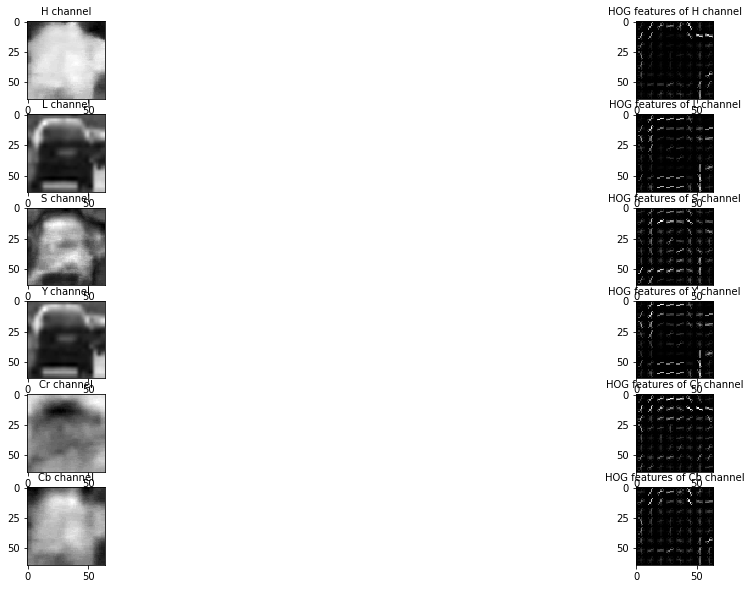

In [136]:
show_sample_hog_features()

### Train Classifier

In [ ]:
svc, X_scaler = train_classifier()

### Run on Test Images, without HOG subsampling

In [8]:
image_folder = "test_images"
image_files = ["test1.jpg", "test2.jpg", "test3.jpg", "test4.jpg", "test5.jpg", "test6.jpg",]
image_displays = []

for image_file in image_files:
    image_file_path = image_folder + "/" + image_file
    image, raw_image = read_image(image_file_path)
    window_img = test_detection(image, raw_image, svc, X_scaler)
    image_displays.append(ImageDisplay(window_img, image_file_path, 'hot'))

show_multiple(image_displays)

Feature vector length: 6108
32.32 Seconds to train SVC...
Test Accuracy of SVC =  0.9918
image canvas with 2 cols and 3 rows
test_images/test1.jpg goes to 0 0
test_images/test2.jpg goes to 0 1
test_images/test3.jpg goes to 1 0
test_images/test4.jpg goes to 1 1
test_images/test5.jpg goes to 2 0
test_images/test6.jpg goes to 2 1


### Run pipeline on single image(s)

In [155]:
RuntimeData().reset()
RuntimeData().resetCaches()

image_folder = "test_images"
output_image_folder = "output_images"
#image_files = ["img_0.jpg", "img_1.jpg", "img_2.jpg", "img_3.jpg", "img_4.jpg", "img_5.jpg"]
image_displays = []

for i in range(39):
    image_file = "img_"+str(i)+".jpg"
    image_file_path = image_folder + "/" + image_file
    image, raw_image = read_image(image_file_path)
    bbox_img = process_image_vehicle_detection(raw_image)
 
    #bbox_img = bbox_img.astype(int)
    #image_o = cv2.cvtColor(bbox_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite("output_images/img_"+str(i)+"_heatmap.jpg", bbox_img)
    
    #if i > 33:
    #    image_displays.append(ImageDisplay(bbox_img, image_file_path, 'hot'))

#show_multiple(image_displays)

In [147]:
def process_image_vehicle_detection(image):
    image = undist(image)
    
    orig_img = np.copy(image)
    raw_image = np.copy(image)
    
    image = image.astype(np.float32)/255
    
    bbox_img = np.copy(raw_image)
    
    # detect lane lines
    bbox_img = process_image_video1(bbox_img)
    
    if RuntimeData().heatmap is None:
        RuntimeData().heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    draw_img, bbox_list = find_cars(image, raw_image, svc, X_scaler)
    #RuntimeData().addToCaches(draw_img, bbox_list)
    #raw_image, bbox_list = RuntimeData().getNextCache()
    
    RuntimeData().heatmap = add_heat(RuntimeData().heatmap, bbox_list, 10) # 10
    RuntimeData().heatmap = cooldown(RuntimeData().heatmap, 5) # 5
    
    thresholded_heatmap = apply_threshold(RuntimeData().heatmap, 70) # 50, 60
    RuntimeData().heatmap = clip_heatmap(RuntimeData().heatmap, 0, 75) # 0 75
    labels = label(thresholded_heatmap)
    
    heatmap_color_img = np.dstack((RuntimeData().heatmap, np.zeros_like(RuntimeData().heatmap), np.zeros_like(RuntimeData().heatmap)))
    
    draw_img = draw_labeled_bboxes(bbox_img, labels)
    
    return heatmap_color_img
    #return bbox_img
    #return concatenate_4_images(raw_image, draw_img, bbox_img, heatmap_color_img)

### Calibrate

In [76]:
# Calibrate
ret, mtx, dist, rvecs, tvecs = calibrate(9, 6)

### Pipeline used for videos

In [140]:
%matplotlib inline
left_line = Line()
right_line = Line()
RuntimeData().reset()
RuntimeData().resetCaches()

video = "test_video"
#video = "project_video"
#video = "project_video_short"
#video = "challenge_video"
#video = "harder_challenge_video"

mode = "final"
#mode = "with_pipeline_1"

white_output = video + "_" + mode + "_out.mp4"
clip1 = VideoFileClip(video + ".mp4")

# choose pipeline
#white_clip = clip1.fl_image(process_image_video1)
white_clip = clip1.fl_image(process_image_vehicle_detection)
#white_clip = clip1.fl_image(process_image)
#white_clip = clip1.fl_image(process_image_find_cspace)

%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_video_final_out.mp4
[MoviePy] Writing video test_video_final_out.mp4


 97%|█████████▋| 38/39 [00:25<00:00,  1.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_final_out.mp4 

CPU times: user 24.5 s, sys: 1.31 s, total: 25.8 s
Wall time: 28.6 s
